<a href="https://colab.research.google.com/github/lingfang23/Take-Home-Challenge/blob/main/Personal_Loan_Repaid_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have access to a specific bank loan data. We have data about all loans asked to the bank, whether the bank decided to grant it and, finally, whether the borrower managed to repay it. We also have info about the person asking for the loan at the moment she is asking for the loan.



In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
loan = pd.read_csv('/content/drive/MyDrive/loan/loan_table.csv')
borrower = pd.read_csv('/content/drive/MyDrive/loan/borrower_table.csv')

### Data Processing


collect oil_price and interest rate for improving models

In [3]:
!pip install quandl
import quandl

# Set your API key (replace YOUR_API_KEY with your actual API key)
quandl.ApiConfig.api_key = "o_AJUgtawdaM7jzvbs-R"

# Set the start and end dates
start_date = "2012-01-01"
end_date = "2012-12-31"

# Get the data for WTI crude oil prices for 2012
oil_price = quandl.get("EIA/PET_RWTC_D", start_date=start_date, end_date=end_date)

print(oil_price.head())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
             Value
Date              
2012-01-03  102.96
2012-01-04  103.22
2012-01-05  101.81
2012-01-06  101.56
2012-01-09  101.31


In [55]:
!pip install fredapi

from fredapi import Fred
import pandas as pd

fred = Fred(api_key='9b818e9b121ea014b2224c2d33ee77d2')

intrest_data = fred.get_series('FEDFUNDS', start_date='2012-01-01', end_date='2012-12-31')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
intrest = intrest_data.to_frame().rename(columns={0: 'Interest_rate'}).reset_index()
intrest = intrest.rename(columns={"index": "date"})

In [74]:
intrest['year'] = intrest['date'].apply(lambda x: x.year)
intrest['month'] = intrest['date'].apply(lambda x: x.month)

In [75]:
intrest = intrest[intrest["year"] == 2012].drop(["date","year"],axis =1)

In [77]:
intrest.head()

,Interest_rate,month
690,0.08,1
691,0.10,2
692,0.13,3
693,0.14,4
694,0.16,5


In [4]:
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [5]:
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [6]:
duplicates = loan['loan_id'].duplicated().sum()
duplicates

0

In [7]:
loan['date'] = pd.to_datetime(loan['date'])
earliest_date = loan['date'].min()
latest_date = loan['date'].max()

# Calculate the duration between the earliest and latest dates
duration = latest_date - earliest_date

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")
print(f"Duration: {duration}")

Earliest date: 2012-01-02 00:00:00
Latest date: 2012-12-28 00:00:00
Duration: 361 days 00:00:00


In [8]:
loan.isna().sum()
# na in loan_repaid means this loan is not granted

loan_id             0
loan_purpose        0
date                0
loan_granted        0
loan_repaid     53446
dtype: int64

In [9]:
borrower.isna().sum()
# if it's the first loan then fully_repaid_previous_loans and currently_repaying_other_loans will be NA

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [10]:
print(loan.shape)
print(borrower.shape)

(101100, 5)
(101100, 12)


In [11]:
loan.describe()

,loan_id,loan_granted,loan_repaid
count,101100.000000,101100.000000,47654.000000
mean,499666.826726,0.471355,0.644353
std,288662.006929,0.499181,0.478714
min,30.000000,0.000000,0.000000
25%,250333.750000,0.000000,0.000000
50%,499885.000000,0.000000,1.000000
75%,749706.250000,1.000000,1.000000
max,999987.000000,1.000000,1.000000


In [12]:
borrower.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
count,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748
std,288662.006929,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
25%,250333.750000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000
50%,499885.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000
75%,749706.250000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000
max,999987.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000


In [13]:
oil_price = oil_price.reset_index().rename(columns={'Date': 'date'})

In [80]:
#merge dataset

df = pd.merge(loan, borrower, on='loan_id', how='left')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].apply(lambda x: x.month)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df = pd.merge(df, oil_price, on='date', how='left')
df = df.rename(columns={'Value': 'Oil_price'})
df = pd.merge(df, intrest, on='month', how='left')
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,dayofweek,Oil_price,Interest_rate
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7,3,3,105.19,0.13
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5,1,1,100.70,0.08
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4,2,3,99.88,0.10
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,6,2,80.27,0.16
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4,5,0,92.57,0.16


### EDA

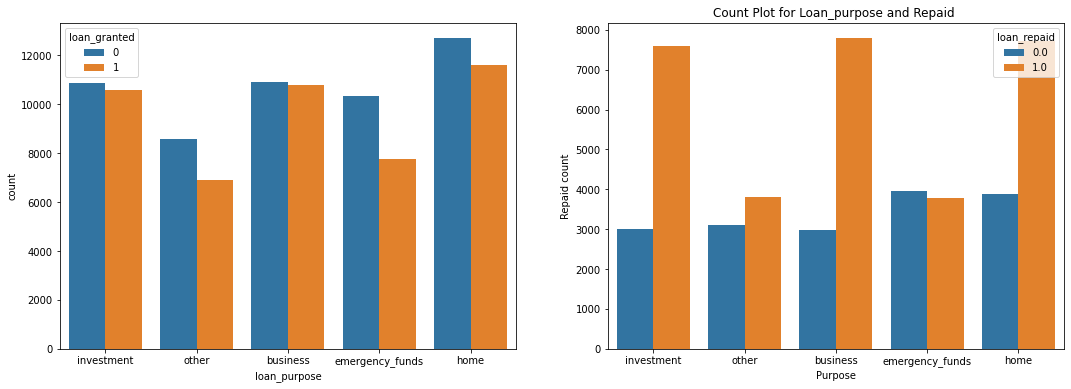

In [81]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=df, x='loan_purpose', hue='loan_granted',ax=ax1)

# Set the title and axis labels
plt.title("Count Plot for Loan_purpose and Granted")
plt.xlabel("Purpose")
plt.ylabel("Granted count")

sns.countplot(data=df, x='loan_purpose', hue='loan_repaid',ax=ax2)

# Set the title and axis labels
plt.title("Count Plot for Loan_purpose and Repaid ")
plt.xlabel("Purpose")
plt.ylabel("Repaid count")


# Display the plot
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


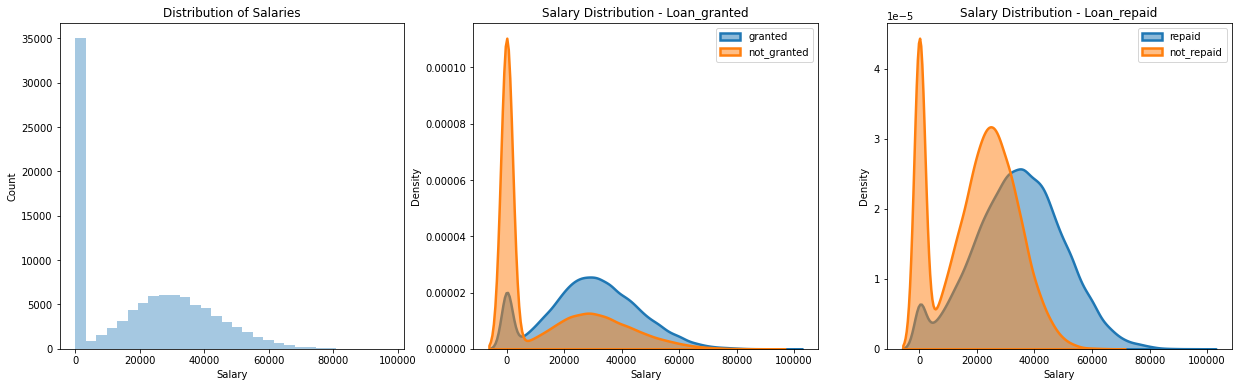

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(21, 6))

sns.distplot(df["yearly_salary"], kde=False, bins=30, ax=ax1)

# Add labels and a title
ax1.set_xlabel('Salary')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Salaries')

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_granted"] == 1]["yearly_salary"], label='granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
sns.kdeplot(df[df["loan_granted"] == 0]["yearly_salary"], label='not_granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
ax2.set_title("Salary Distribution - Loan_granted")
ax2.set_xlabel("Salary")
ax2.set_ylabel("Density")
ax2.legend() 

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_repaid"] == 1]["yearly_salary"], label='repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax3)
sns.kdeplot(df[df["loan_repaid"] == 0]["yearly_salary"], label='not_repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax3)
ax3.set_title("Salary Distribution - Loan_repaid")
ax3.set_xlabel("Salary")
ax3.set_ylabel("Density")
ax3.legend() 
# Display the plot
plt.show()

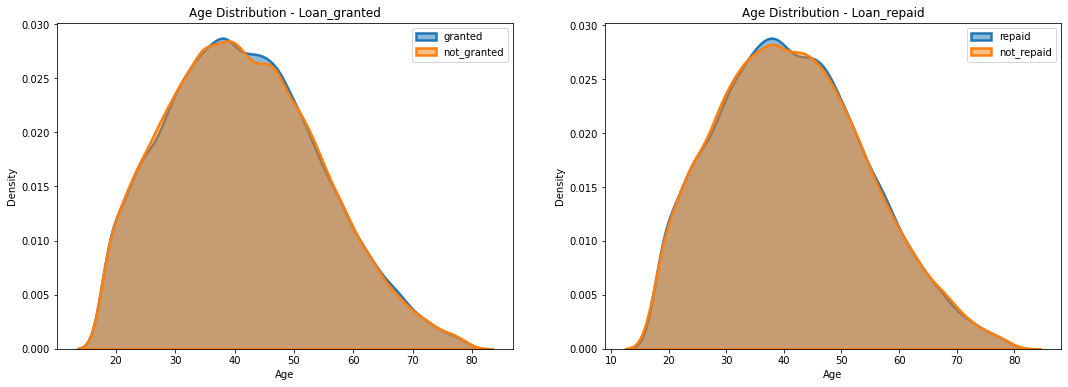

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_granted"] == 1]["age"], label='granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
sns.kdeplot(df[df["loan_granted"] == 0]["age"], label='not_granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
ax1.set_title("Age Distribution - Loan_granted")
ax1.set_xlabel("Age")
ax1.set_ylabel("Density")
ax1.legend() 

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_repaid"] == 1]["age"], label='repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
sns.kdeplot(df[df["loan_repaid"] == 0]["age"], label='not_repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
ax2.set_title("Age Distribution - Loan_repaid")
ax2.set_xlabel("Age")
ax2.set_ylabel("Density")
ax2.legend() 

# Display the plot
plt.show()

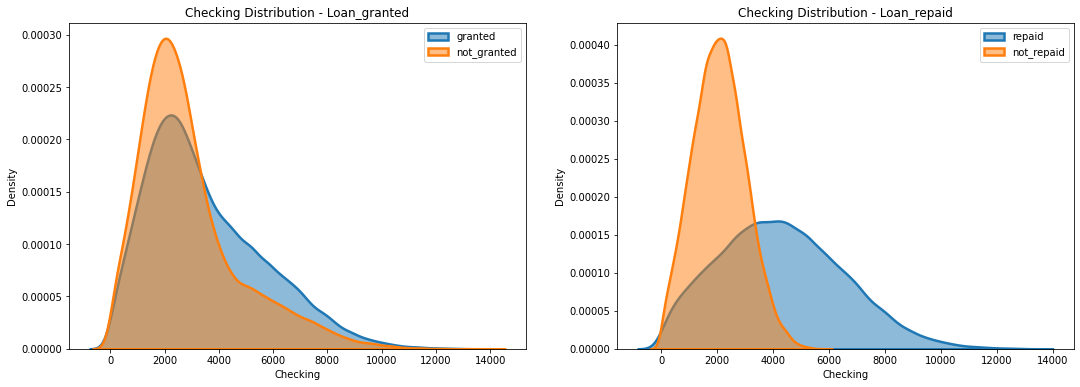

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_granted"] == 1]["checking_amount"], label='granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
sns.kdeplot(df[df["loan_granted"] == 0]["checking_amount"], label='not_granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
ax1.set_title("Checking Distribution - Loan_granted")
ax1.set_xlabel("Checking")
ax1.set_ylabel("Density")
ax1.legend() 
# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_repaid"] == 1]["checking_amount"], label='repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
sns.kdeplot(df[df["loan_repaid"] == 0]["checking_amount"], label='not_repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
ax2.set_title("Checking Distribution - Loan_repaid")
ax2.set_xlabel("Checking")
ax2.set_ylabel("Density")
ax2.legend() 

# Display the plot
plt.show()

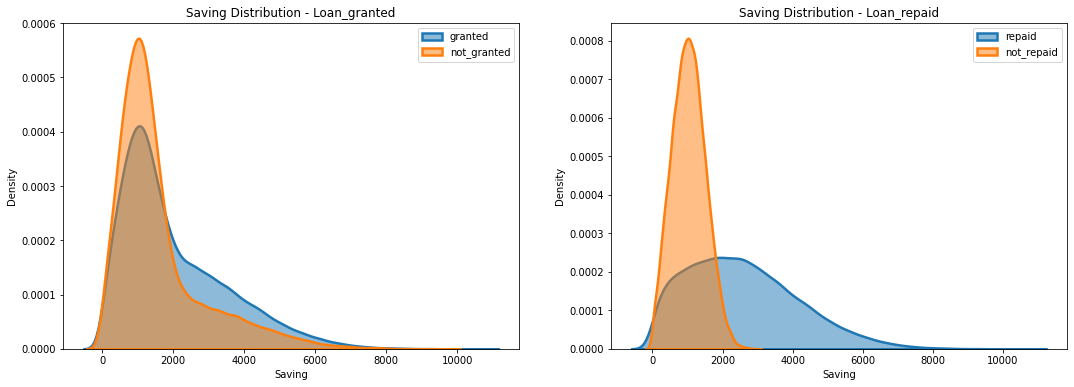

In [85]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))


# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_granted"] == 1]["saving_amount"], label='granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
sns.kdeplot(df[df["loan_granted"] == 0]["saving_amount"], label='not_granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
ax1.set_title("Saving Distribution - Loan_granted")
ax1.set_xlabel("Saving")
ax1.set_ylabel("Density")
ax1.legend() 
# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_repaid"] == 1]["saving_amount"], label='repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
sns.kdeplot(df[df["loan_repaid"] == 0]["saving_amount"], label='not_repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
ax2.set_title("Saving Distribution - Loan_repaid")
ax2.set_xlabel("Saving")
ax2.set_ylabel("Density")
ax2.legend() 

# Display the plot
plt.show()

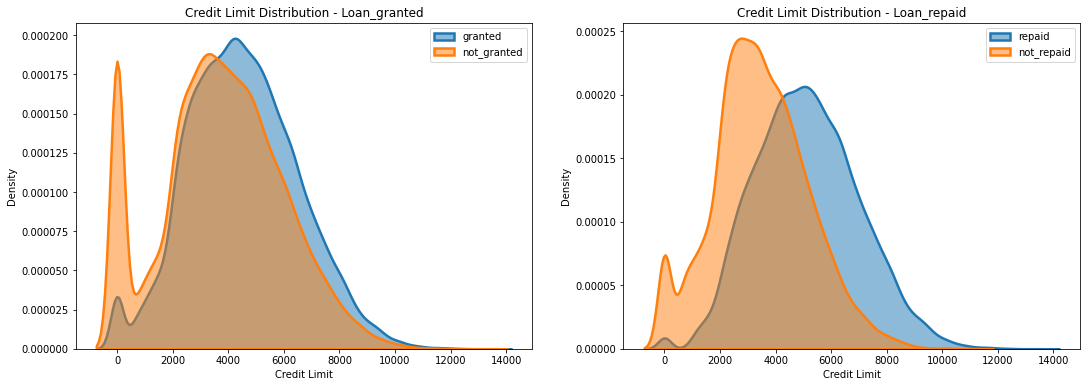

In [86]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_granted"] == 1]["total_credit_card_limit"], label='granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
sns.kdeplot(df[df["loan_granted"] == 0]["total_credit_card_limit"], label='not_granted', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax1)
ax1.set_title("Credit Limit Distribution - Loan_granted")
ax1.set_xlabel("Credit Limit")
ax1.set_ylabel("Density")
ax1.legend() 
# Create a box plot of the salary data in the subplot
sns.kdeplot(df[df["loan_repaid"] == 1]["total_credit_card_limit"], label='repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
sns.kdeplot(df[df["loan_repaid"] == 0]["total_credit_card_limit"], label='not_repaid', fill=True, alpha=.5, common_norm=False, linewidth=2.5, linestyle="-",ax=ax2)
ax2.set_title("Credit Limit Distribution - Loan_repaid")
ax2.set_xlabel("Credit Limit")
ax2.set_ylabel("Density")
ax2.legend() 

# Display the plot
plt.show()

<AxesSubplot:xlabel='loan_repaid', ylabel='avg_percentage_credit_card_limit_used_last_year'>

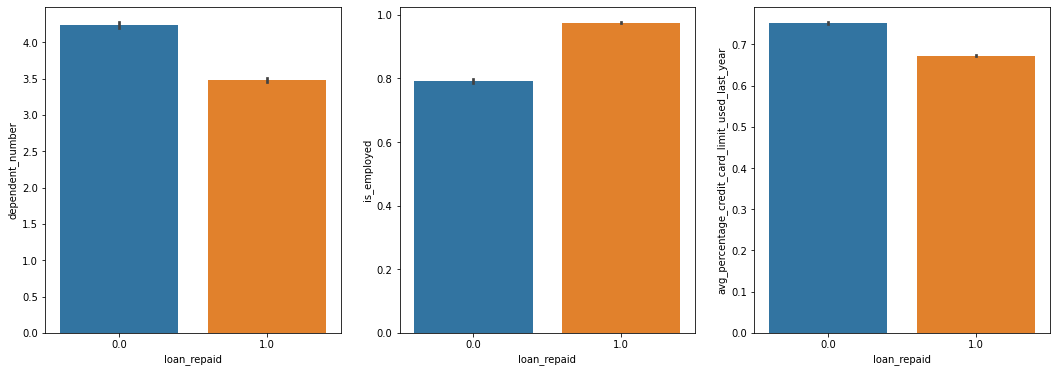

In [87]:
fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
sns.barplot(x='loan_repaid', y='dependent_number', data=df, ax=ax1)
sns.barplot(x='loan_repaid', y='is_employed', data=df, ax=ax2)
sns.barplot(x='loan_repaid', y='avg_percentage_credit_card_limit_used_last_year', data=df, ax=ax3)


<AxesSubplot:xlabel='loan_repaid', ylabel='currently_repaying_other_loans'>

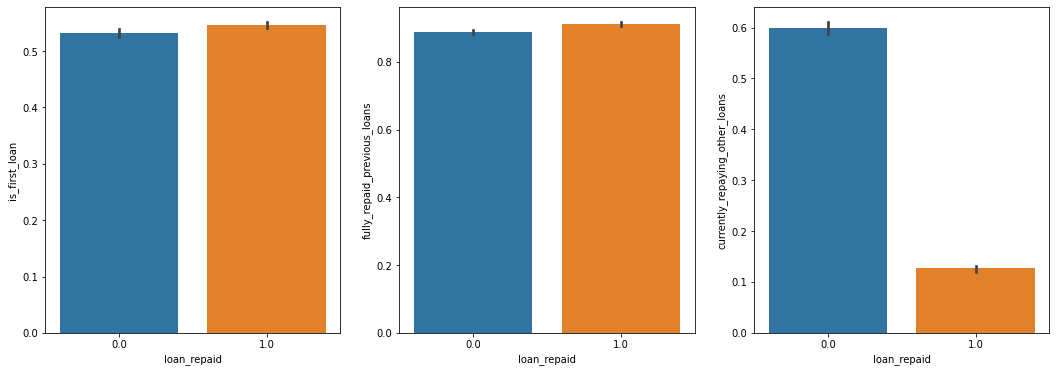

In [88]:
fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
sns.barplot(x='loan_repaid', y='is_first_loan', data=df, ax=ax1)
sns.barplot(x='loan_repaid', y='fully_repaid_previous_loans', data=df, ax=ax2)
sns.barplot(x='loan_repaid', y='currently_repaying_other_loans', data=df, ax=ax3)

<AxesSubplot:xlabel='loan_repaid', ylabel='Oil_price'>

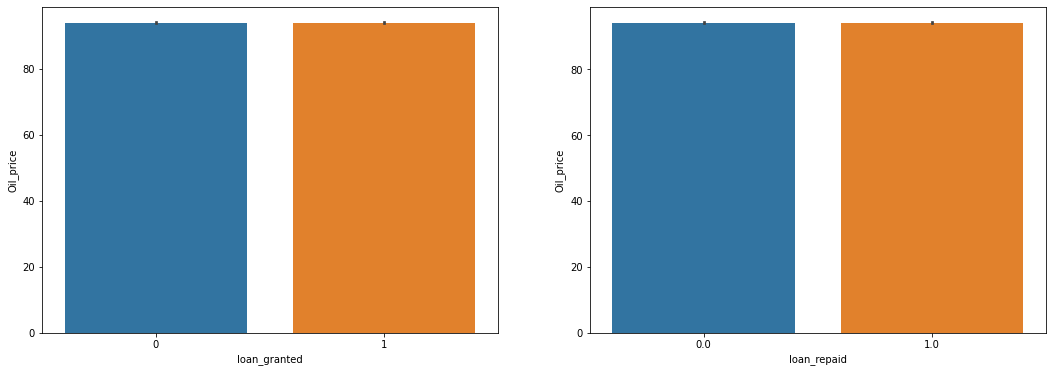

In [89]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18,6))
sns.barplot(x='loan_granted', y='Oil_price', data=df, ax=ax1)
sns.barplot(x='loan_repaid', y='Oil_price', data=df, ax=ax2)

In [90]:
df = pd.get_dummies(df, drop_first = True)

In [91]:
df = df.drop(labels=['loan_id', 'date'], axis=1, inplace=False)

In [92]:
# fill missing values with -1 for 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
df = df.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

# fill missing values with median
median_credit = df['avg_percentage_credit_card_limit_used_last_year'].median()
median_oil = df['Oil_price'].median()
df = df.fillna({'avg_percentage_credit_card_limit_used_last_year': median_credit})
df = df.fillna({'Oil_price': median_oil})

In [93]:
df.head()

,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,...,age,dependent_number,month,dayofweek,Oil_price,Interest_rate,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other
0,0,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,1,...,42,7,3,3,105.19,0.13,0,0,1,0
1,0,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,...,42,5,1,1,100.70,0.08,0,0,1,0
2,0,NaN,1,-1.0,-1.0,0,0.73,660,3232,1,...,60,4,2,3,99.88,0.10,0,0,0,1
3,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,...,58,4,6,2,80.27,0.16,0,0,0,1
4,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,...,31,4,5,0,92.57,0.16,0,0,0,0


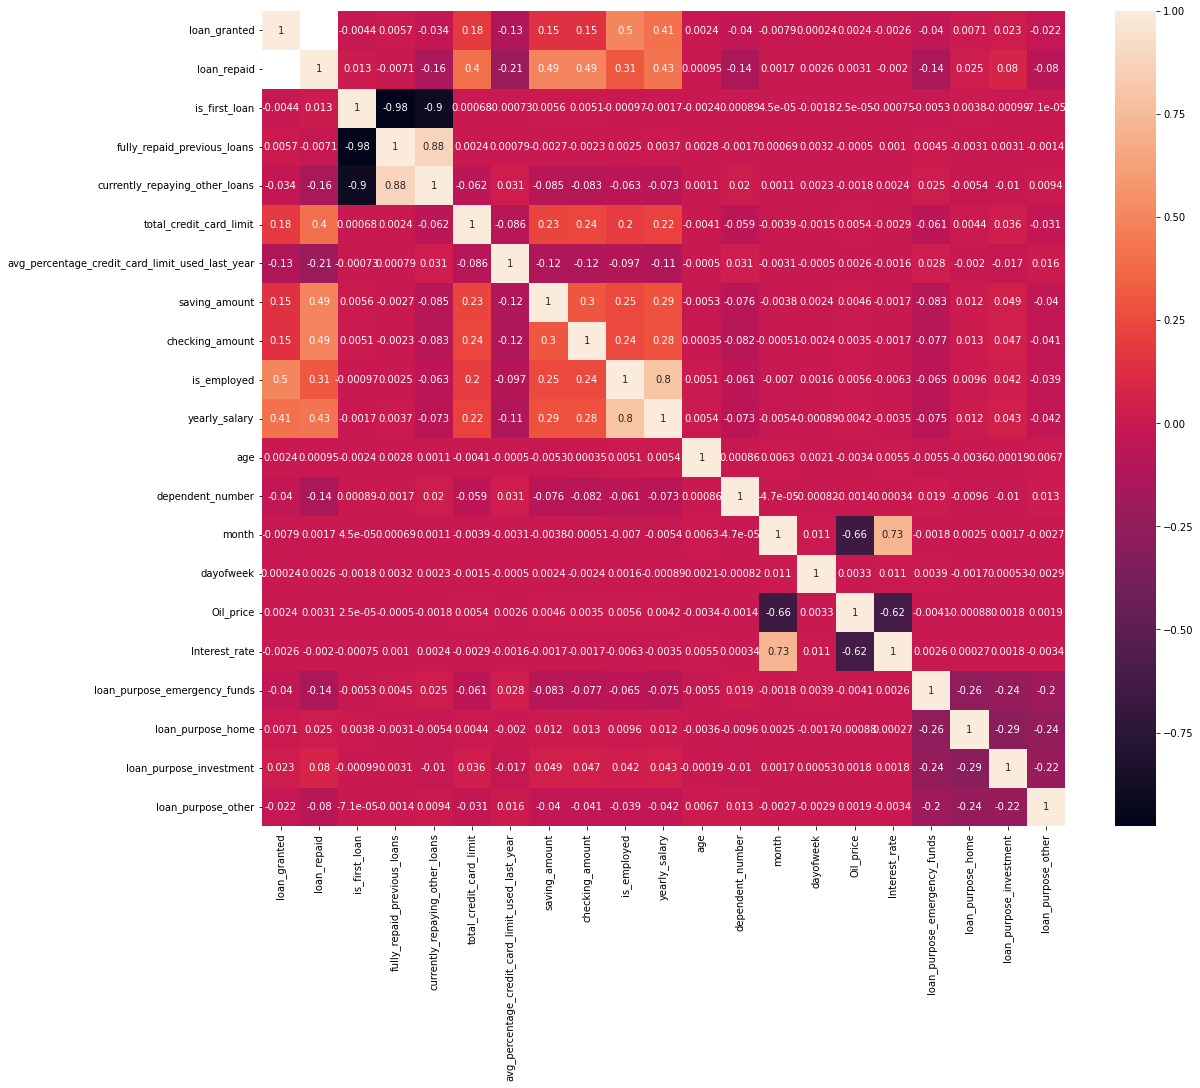

In [94]:
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df.corr(), ax=ax, annot=True)
plt.show()

### EDA Insight

*   According to the data, only 47% of loan applications were granted, and only 64% of loans were repaid. It appears that **this company has a lower loan approval rate and a higher delinquency rate compared to industry averages**, which may suggest that **the company is attracting a riskier pool of borrowers**. This could be due to a variety of factors, such as looser lending standards, less stringent credit checks, or a higher concentration of borrowers with lower credit scores or higher debt levels. To better understand the underlying reasons for these trends and mitigate the associated risks, the company may want to conduct further analysis on its borrower demographics, loan underwriting process, and collection practices.


*   The mean salary of $21020 and the distribution suggests that this company primarily serves middle and lower-class borrowers who may have limited financial resources and a higher risk of defaulting on their loans, particularly during economic downturns or unexpected financial hardships.


*   Given that **borrowers' ability to repay their debts can be impacted by their currectly paying debts**, it's important for lenders to carefully assess a borrower's overall debt burden when approving loans. In this case, the data suggests that limiting the loan amount offered to borrowers may be a prudent strategy, as it can help ensure that borrowers are not overextended and have a greater likelihood of repaying their debts. However, it's important to note that this approach may also limit the company's revenue potential, so a balance must be struck between managing risk and driving growth.




## Machine Learning model - Granted


In [95]:
# data = pd.read_csv('/content/drive/MyDrive/loan/p_loan.csv')

In [96]:
grant = df.drop(["loan_repaid"], axis = 1)
repaid = df[df["loan_granted"] == 1].drop(["loan_granted"], axis = 1)

In [97]:
repaid['loan_repaid'] = repaid['loan_repaid'].astype(str)

In [98]:
grant.isna().sum()

loan_granted                                       0
is_first_loan                                      0
fully_repaid_previous_loans                        0
currently_repaying_other_loans                     0
total_credit_card_limit                            0
avg_percentage_credit_card_limit_used_last_year    0
saving_amount                                      0
checking_amount                                    0
is_employed                                        0
yearly_salary                                      0
age                                                0
dependent_number                                   0
month                                              0
dayofweek                                          0
Oil_price                                          0
Interest_rate                                      0
loan_purpose_emergency_funds                       0
loan_purpose_home                                  0
loan_purpose_investment                       

In [99]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

### Logistic Regression


In [100]:
X = grant.drop('loan_granted', axis=1)
y = grant['loan_granted']

# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# standardize for logistic regrssion
scaler = StandardScaler()
X_train_sd = scaler.fit_transform(X_train)
X_test_sd = scaler.transform(X_test)

lgr = LogisticRegression(solver='liblinear', penalty = "l1", max_iter=500)
lgr.fit(X_train_sd, y_train)

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}
gs_lg = GridSearchCV(estimator=lgr, param_grid=param)
gs_lg.fit(X_train_sd, y_train)

# Train a LR model with best parameters
lgr_r = LogisticRegression(**gs_lg.best_params_, penalty='l1', solver='liblinear')
lgr_r.fit(X_train_sd, y_train)

predictions = lgr_r.predict(X_train_sd)

# use cross validation to tune our model
score = cross_val_score(lgr_r, X_train_sd, y_train, cv=5)

print('Accuracy: %.3f' % score.mean())

Accuracy: 0.731


In [102]:
coef = lgr_r.coef_[0]
columns = df.columns.tolist()

for i,v in enumerate(coef):
	print('%0s, Score: %.5f' % (columns[i],v))

loan_granted, Score: 0.00909
loan_repaid, Score: 0.02853
is_first_loan, Score: -0.01293
fully_repaid_previous_loans, Score: 0.22748
currently_repaying_other_loans, Score: -0.18771
total_credit_card_limit, Score: 0.00751
avg_percentage_credit_card_limit_used_last_year, Score: 0.00488
saving_amount, Score: 1.18739
checking_amount, Score: -0.00499
is_employed, Score: 0.00545
yearly_salary, Score: -0.01142
age, Score: -0.02883
dependent_number, Score: -0.00979
month, Score: -0.01975
dayofweek, Score: 0.01415
Oil_price, Score: 0.00283
Interest_rate, Score: 0.01070
loan_purpose_emergency_funds, Score: 0.00593
loan_purpose_home, Score: 0.00919


### Decision Tree

Accuracy: 0.774
[[7152 3484]
 [1076 8508]]
Precision: 0.709
Recall: 0.888


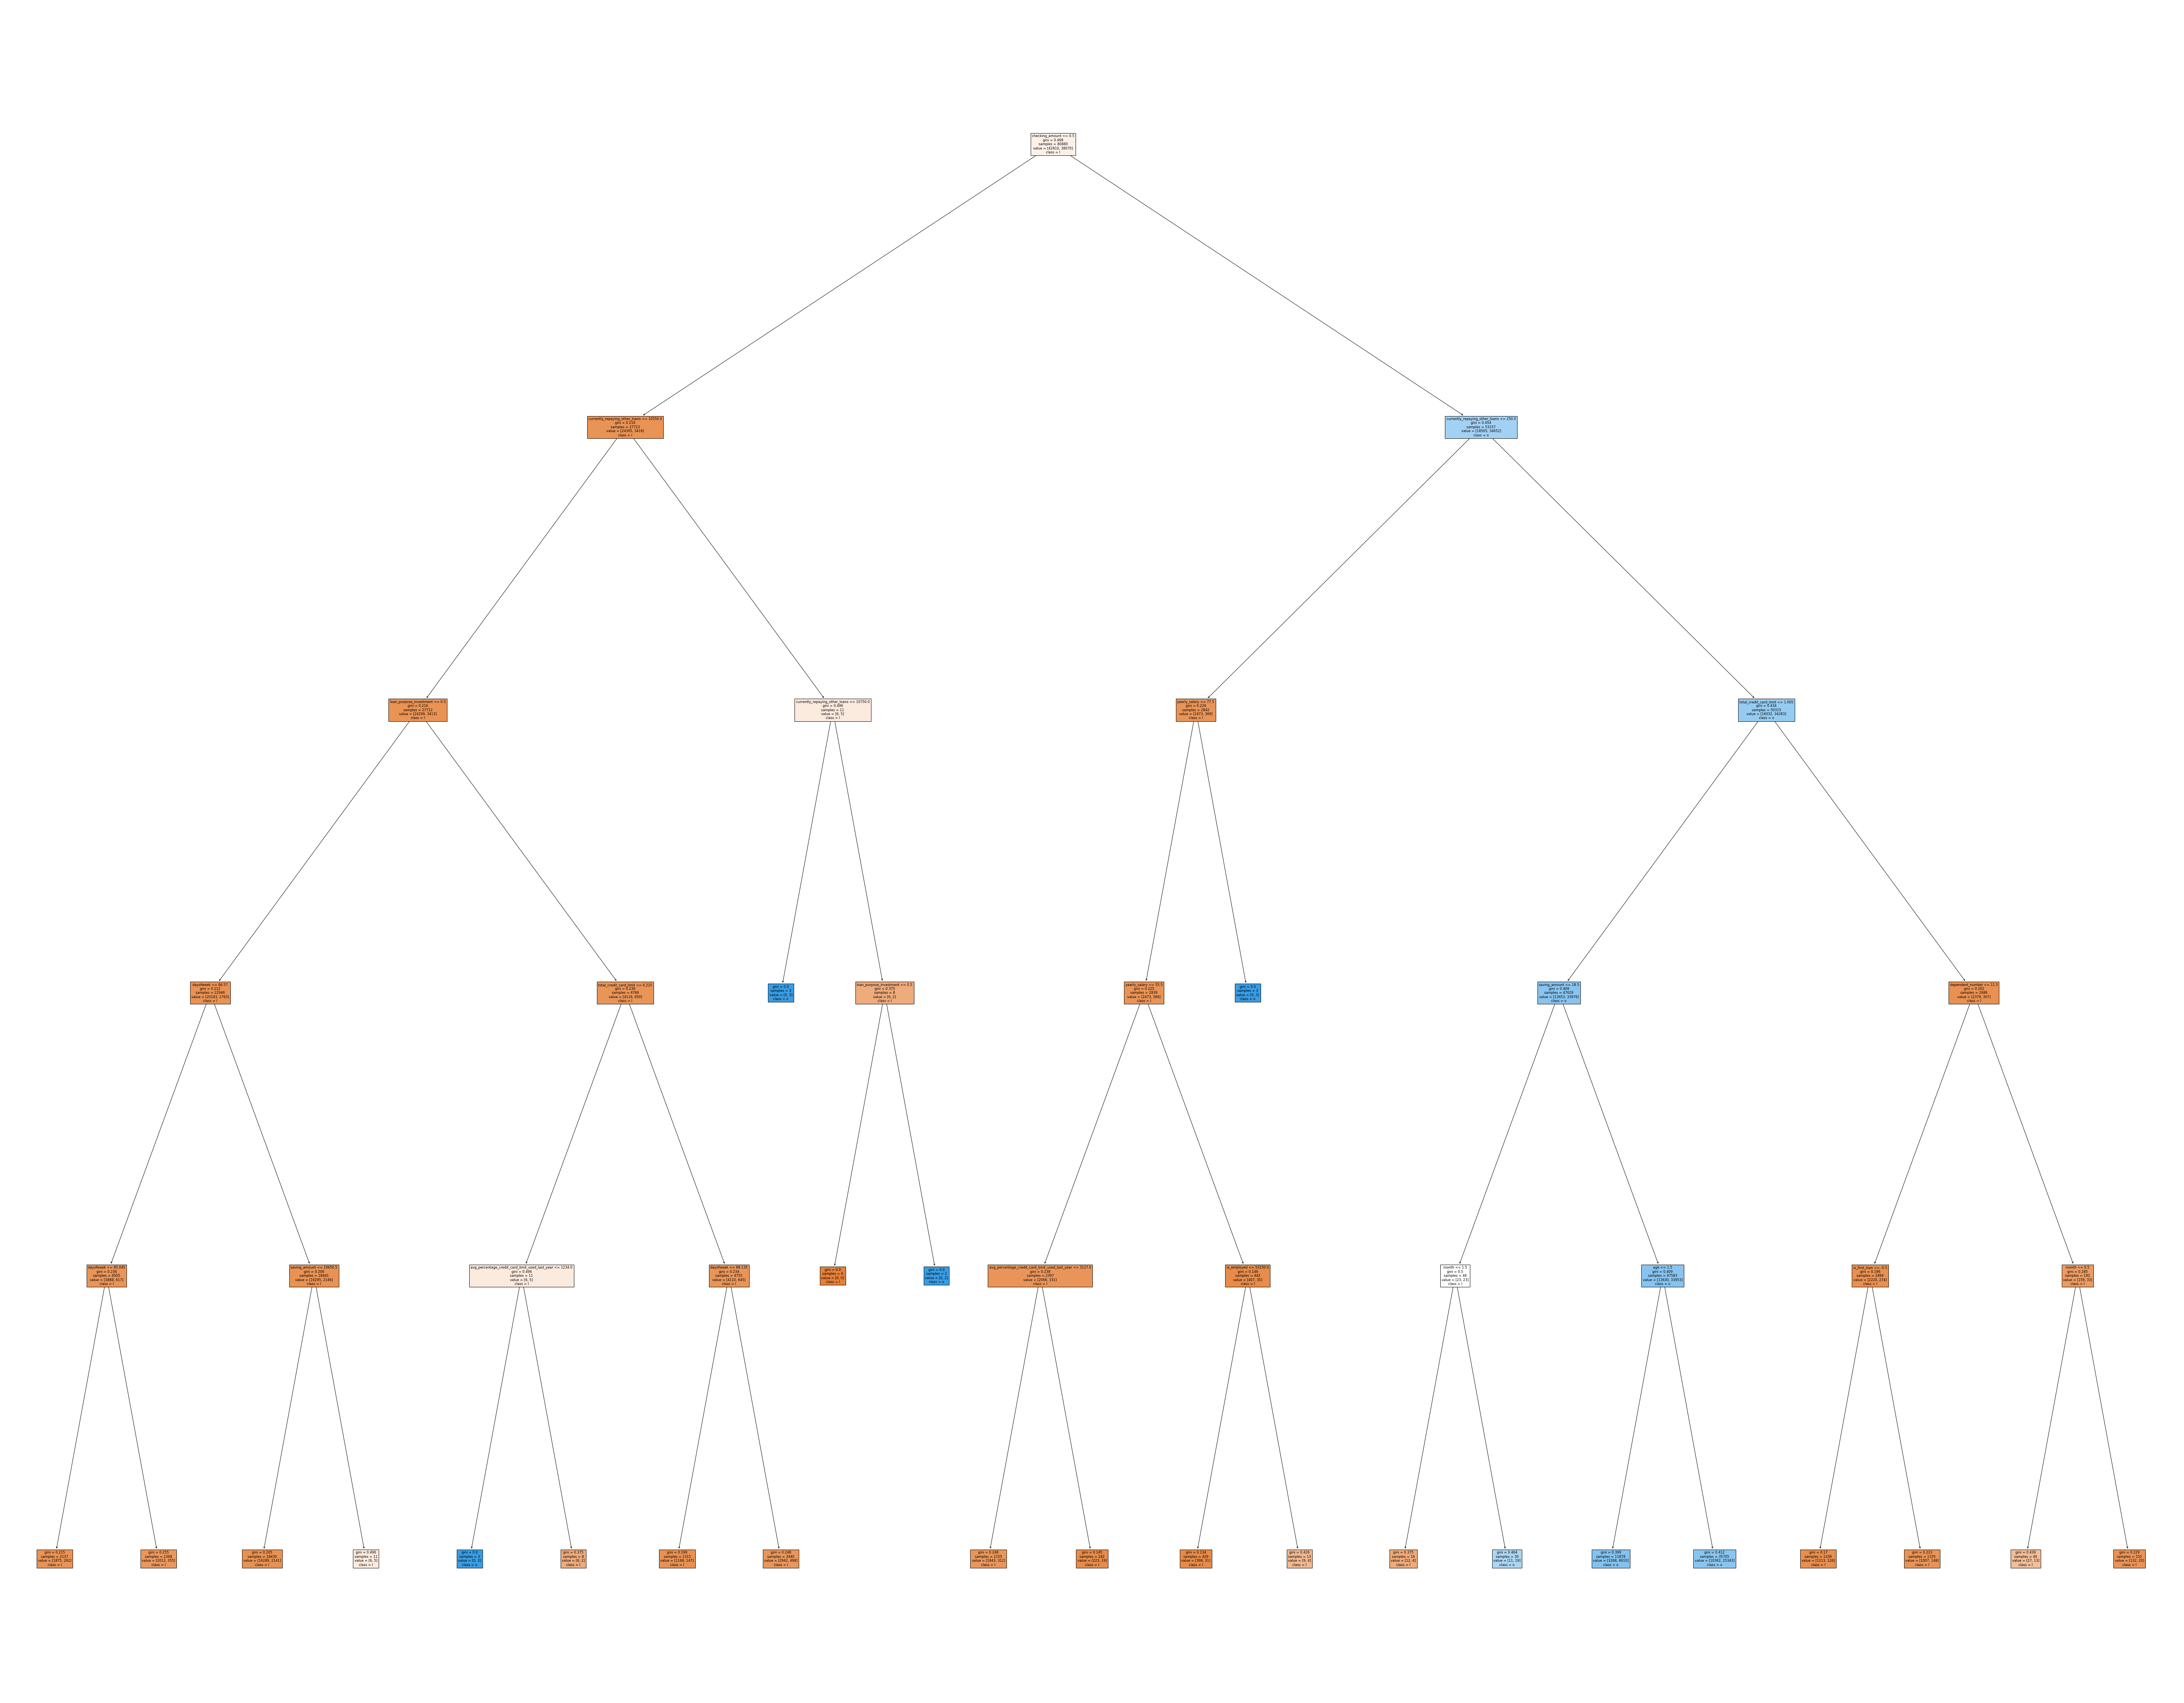

In [103]:
parameters = {'max_depth':range(3,20)}

dt = DecisionTreeClassifier(max_depth = 5, random_state=123)
dt = dt.fit(X_train,y_train)

text_representation = tree.export_text(dt)

fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(dt, 
                   feature_names=grant.columns[:-1],  
                   class_names=grant.columns[-1],
                   filled=True)

dt_pred = dt.predict(X_test)

score = dt.score(X_test, y_test)
print('Accuracy: %.3f' % score)

cm = metrics.confusion_matrix(y_test, dt_pred)
print(cm)	

print('Precision: %.3f' % precision_score(y_test, dt_pred))
print('Recall: %.3f' % recall_score(y_test, dt_pred))

plt.show()

### RandomForest

In [104]:
param_grid = {'max_depth': range(10,20,5),
              'n_estimators':range(30,50,10)}

rf = RandomForestClassifier(criterion='entropy', random_state=123)
rf = HalvingGridSearchCV(rf, param_grid, cv=5).fit(X_train,y_train)
RF = rf.best_estimator_

print(rf.best_score_, rf.best_params_) 

0.7805761622156281 {'max_depth': 10, 'n_estimators': 30}


In [105]:
rf_pred = RF.predict(X_test)

score = RF.score(X_test, y_test)
print('Accuracy: %.3f' % score)

cm = metrics.confusion_matrix(y_test, rf_pred)
print(cm)	

print('Precision: %.3f' % precision_score(y_test, rf_pred))
print('Recall: %.3f' % recall_score(y_test, rf_pred))


Accuracy: 0.775
[[7153 3483]
 [1073 8511]]
Precision: 0.710
Recall: 0.888


### XGBoost

0.780549029306294 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 40}
                                          Attribute  Importance
7                                       is_employed    0.901205
4   avg_percentage_credit_card_limit_used_last_year    0.045507
3                           total_credit_card_limit    0.045111
1                       fully_repaid_previous_loans    0.001949
10                                 dependent_number    0.000646
14                                    Interest_rate    0.000638
12                                        dayofweek    0.000595
8                                     yearly_salary    0.000571
6                                   checking_amount    0.000545
5                                     saving_amount    0.000506
13                                        Oil_price    0.000502
11                                            month    0.000463
9                                               age    0.000410
0                         

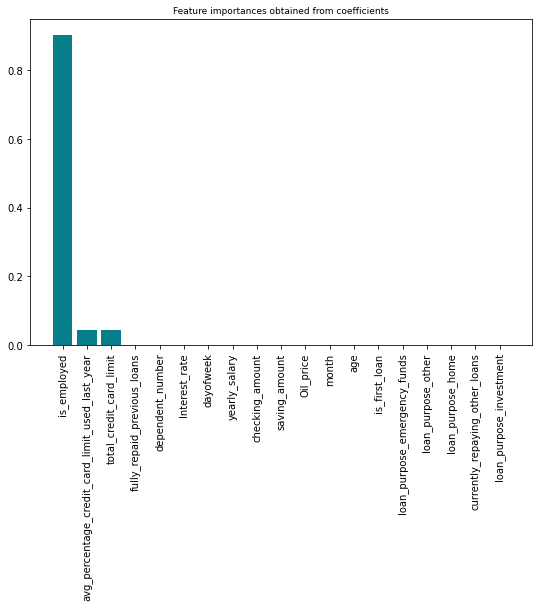

In [106]:
# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
from xgboost import XGBClassifier

parameters = {
    'max_depth': range (5, 10, 3),
    'n_estimators': range(30, 50, 10),
    'learning_rate': [0.1, 0.01, 0.05]
}

xg = XGBClassifier(random_state=123)
xg = HalvingGridSearchCV(xg, parameters, cv=5).fit(X_train,y_train)
XGBoost = xg.best_estimator_

print(xg.best_score_, xg.best_params_) 

importances = XGBoost.feature_importances_

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': XGBoost.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

print("\n")
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=9)
plt.rcParams["figure.figsize"] = (9,6)
plt.xticks(rotation='vertical')
plt.show()


In [115]:
xg_pred = XGBoost.predict(X_test)

score = XGBoost.score(X_test, y_test)
print('\n Accuracy: %.3f' % score)
print('\n confussion matrix:\n',confusion_matrix(y_test, xg_pred))
print('\n ROC AUC:',roc_auc_score(y_test, xg_pred))
print('\n Precision: %.3f' % precision_score(y_test, xg_pred))
print('\n Recall: %.3f' % recall_score(y_test, xg_pred))


 Accuracy: 0.775

 confussion matrix:
 [[7153 3483]
 [1073 8511]]

 ROC AUC: 0.7802849184205091

 Precision: 0.710

 Recall: 0.888
